MACHINE LEARNING - APRENDIZAJE AUTOMÁTICO
Predicción de supervivencia de pasajeros del Titanic

Entrenamiento

In [2]:
import warnings
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
warnings.filterwarnings("ignore")

train_data = pd.read_csv("data/Titanic_train.csv")
test_data = pd.read_csv("data/Titanic_test.csv")

#filas y col de train_data
train_data_shape = train_data.shape
print(train_data_shape)

#tipos de datos entrenamiento
#STD............¿Qué llama la atención?
train_data.info()

(891, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [3]:
#Damos un vistazo a los datos
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#Ver si hay datos nulos
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Ingeniería de características: optimización de datos para el entrenamiento de modelos (EDA, Exploratory Data Analisys)

Podemos ver que en Cabin faltan muchos datos, con lo cual no es un buen campo de análisis. También faltan datos en Age, pero la posibilidad teórica de que la edad haya influido en la supervivencia hace que de momento no descartemos este dato.

Eliminar información irrelevante:

0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  _ supervivencia V
 2   Pclass       891 non-null    int64  _ clase en que viajaban V (1: 1ª, 2: 2ª, 3: 3ª)
 3   Name         891 non-null    object _ nombre X: aunque el nombre también puede ser indicativo de clase social, en esta aproximación lo vamos a descartar como dato relevante
 4   Sex          891 non-null    object _ sexo V
 5   Age          714 non-null    float64 _ edad V: tener en cuenta que hay datos nulos
 6   SibSp        891 non-null    int64  _ Pasajeros que viajaban solos X: descartado en esta aproximación
 7   Parch        891 non-null    int64  _ Pasajeros que viajaban con familia X: descartado en esta aproximación
 *El tamaño de las familias se puede calcular con la suma de 6 y 7.
 8   Ticket       891 non-null    object _ Pasaje X
 9   Fare         891 non-null    float64 _ Tarifa del pasaje V: el precio del pasaje es más indicativo que el pasaje en si o la cabina
 10  Cabin        204 non-null    object _ Cabina X
 11  Embarked     889 non-null    object _ Puerto de embarque V, incluye dos nulos a los que habría que asignarles un valor por defecto si fueramos a usarlo (C: Cherbourg, Q: Queenstown, S: Southampton)

- Survived: num
- Pclass: num
- Sex: categ
- Age: num
- Fare: num
- Embarked: categ

In [5]:
#Eliminar columnas: de los dataframes de entrenamiento y test
train_data = train_data.drop(["Name"], axis=1)
test_data = test_data.drop(["Name"], axis=1)
train_data = train_data.drop(["SibSp"], axis=1)
test_data = test_data.drop(["SibSp"], axis=1)
train_data = train_data.drop(["Parch"], axis=1)
test_data = test_data.drop(["Parch"], axis=1)
train_data = train_data.drop(["Ticket"], axis=1)
test_data = test_data.drop(["Ticket"], axis=1)
train_data = train_data.drop(["Cabin"], axis=1)
test_data = test_data.drop(["Cabin"], axis=1)

<Axes: xlabel='Embarked', ylabel='count'>

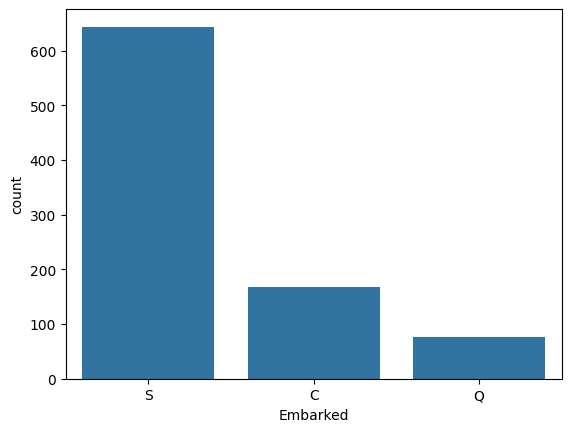

In [6]:
#Embarked tiene datos nulos: vamos a hacer un gráfico para ver la distribución de valores
sns.countplot(x="Embarked", data=train_data,)

In [7]:
#Dado que faltan únicamente 2 datos y la mayoría de pasajeros embarcaron en Southampton, vamos a darles por defecto el valor S
train_data = train_data.fillna({"Embarked": "S"})

#Nos queda asignar valores por defecto a los nulos en edad
train_data = train_data.fillna({"Age": -1})


In [8]:
#Vamos a asignar valores numéricos a las categorías: Sex y Embarked
sex_mapping = {"male": 0, "female":1}
train_data["Sex"] = train_data["Sex"].map(sex_mapping)
test_data["Sex"] = test_data["Sex"].map(sex_mapping)

embarked_mapping = {"S": 1, "C":2, "Q": 3}
train_data["Embarked"] = train_data["Embarked"].map(embarked_mapping)
test_data["Embarked"] = test_data["Embarked"].map(embarked_mapping)


In [9]:
#REVISAMOS LOS DATOS después de la ingeniería de características
#Nota: no hemos comprobado en este caso duplicados: queda a instancia de los alumnos comprobar si hay pasajeros duplicados y en caso afirmativo eliminar duplicados (dataxxx.drop("PassengerId", axis = 1).duplicated().sum())

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   Fare         891 non-null    float64
 6   Embarked     891 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 48.9 KB


In [10]:
#Vamos a revisar también los datos del grupo test

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          332 non-null    float64
 4   Fare         417 non-null    float64
 5   Embarked     418 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 19.7 KB


In [11]:
#Solucionamos los problemas con los datos del grupo test y revisamos

#Asignar valores por defecto a los nulos en edad
test_data = test_data.fillna({"Age": -1})

#Tarifa: en los faltantes añadiremos por defecto la tarifa media para la clase en la que viaja el pasajero
for x in range(len(test_data["Fare"])):
    if pd.isnull(test_data["Fare"][x]):
        passenger_class = test_data["Pclass"][x]
        #print(passenger_class)
        calc_fare = round(train_data[train_data["Pclass"] == passenger_class]["Fare"].mean(), 4)
        #print(calc_fare)
        test_data["Fare"][x] = calc_fare

test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float64
 4   Fare         418 non-null    float64
 5   Embarked     418 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 19.7 KB


Estudiar los datos (opcional) -> Hacer un diagrama de pares para graficar todas las relaciones entre las columnas, por supervivencia

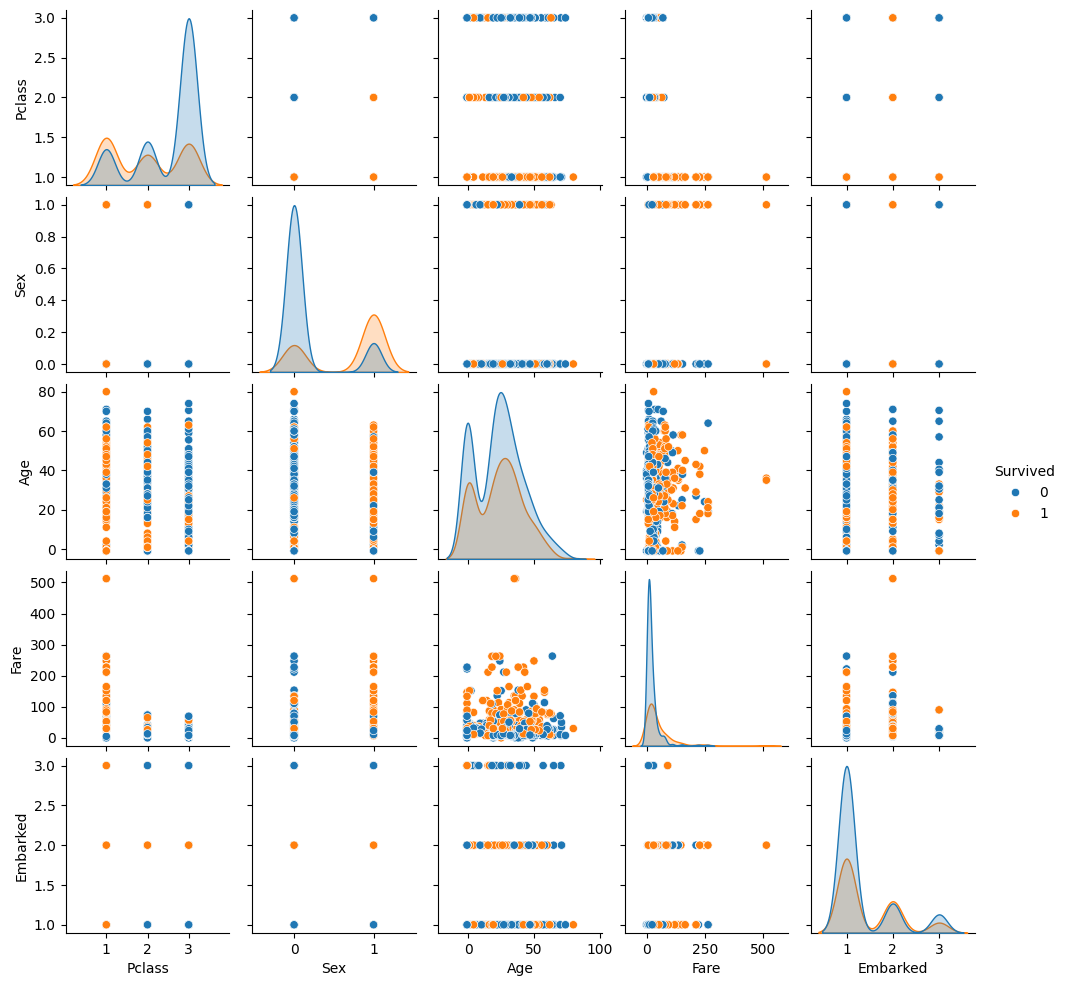

In [12]:
sns.pairplot(train_data.drop(['PassengerId'], axis = 1), hue='Survived', height=2)

#STD..............¿Conclusiones de estos gráficos?

¿Influyó el sexo en las posibilidades de supervivencia?

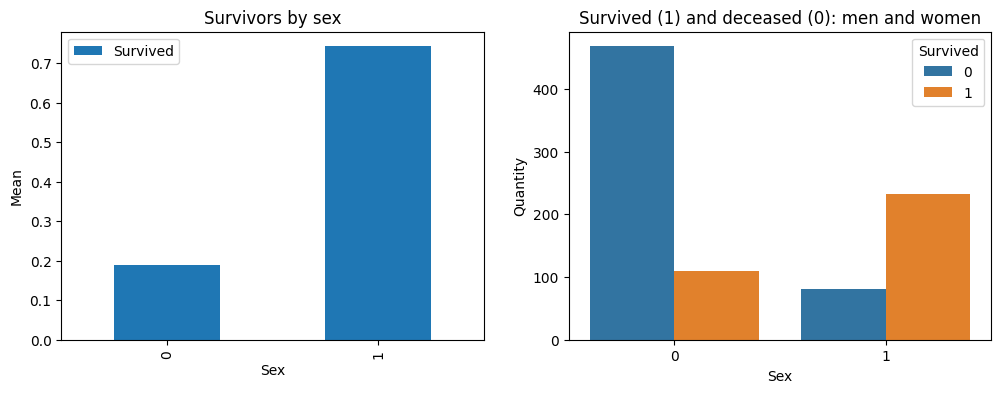

In [13]:
f, ax = plt.subplots(1, 2, figsize=(12, 4)) 
train_data[['Sex', 'Survived']].groupby(['Sex']).mean().plot.bar(ax=ax[0]) 
ax[0].set_ylabel('Mean')
ax[0].set_title('Survivors by sex') 
sns.countplot(x='Sex', hue='Survived', data=train_data, ax=ax[1])
ax[1].set_ylabel('Quantity') 
ax[1].set_title('Survived (1) and deceased (0): men and women') 
plt.show()

<Axes: xlabel='Sex', ylabel='Age'>

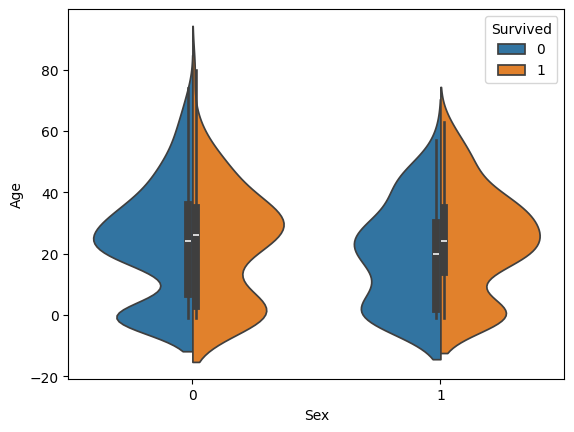

In [14]:
#gráfico de violín para ver la distribución por sexo y edad
sns.violinplot(x="Sex", y="Age", hue="Survived", data=train_data, split=True)
#sns.stripplot(data=train_data["Age"], color="green")
#sns.stripplot(x="Sex", y="Age", data=train_data, color="green")

Entrenar el modelo: contruir el modelo predictivo
Usar el algoritmo del bosque aleatorio (random forest): robusto y con capacidad para manejar datos diversos.
- Dividir los datos en subconjuntos entrenamiento - prueba (80% - 20%) con train_test_split
- Evaluar la precisión del modelo empleado

In [15]:
from sklearn.model_selection import train_test_split

# Eliminar las columnas Survived y PassengerId para el entrenamiento
predictors = train_data.drop(['Survived', 'PassengerId'], axis=1)
target = train_data["Survived"]
#Para entrenar el modelo indicamos: las columnas que van a ayudar a predecir(elminada la columna traget de la predicción y en este caso el IdPasajero que no es informativo), la columna a predecir, el subconjunto de test (20%, el resto será entrenamiento) y random_state a 0 (default None) para que el "bosque de matrices" creado en el algoritmo sea diferente cada vez, es decir, que el algoritmo no este determinado (si ponemos un valor >=0 determinaremos la ejecución y obtendremos un resultado más repetitivo en diferentes ejecuciones en detrimento de la aleatoridad propia de ML en este ejemplo)
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size=0.2, random_state=0)


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

randomforest = RandomForestClassifier()

#Aplicamos randomforest a los predictores y el test que hemos fijado antes y obtenemos la predicción para el target
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)

#Preguntamos por la precisión de nuestro modelo entrenado ¿cuánto de lo predicho se ajusta en los datos de entrenamiento (80:20)?
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print("RF algortim accuracy ", acc_randomforest)


RF algortim accuracy  83.24


Vamos a generar las predicciones de supervivencia en los datos de test.
Guardaremos los datos en un archivo .csv

In [17]:
#guardo los ids porque los voy a borrar para la predicción
ids = test_data["PassengerId"]
predictions = randomforest.predict(test_data.drop("PassengerId", axis=1))

#guardamos la salida como un dataframe
pred_output = pd.DataFrame({"PassengerId": ids, "Survived": predictions, "Pclass": test_data["Pclass"], "Sex" : test_data["Sex"], "Age": test_data["Age"], "Fare": test_data["Fare"], "Embarked": test_data["Embarked"]})
pred_output.to_csv("data/Titanic_result.csv", index=False)


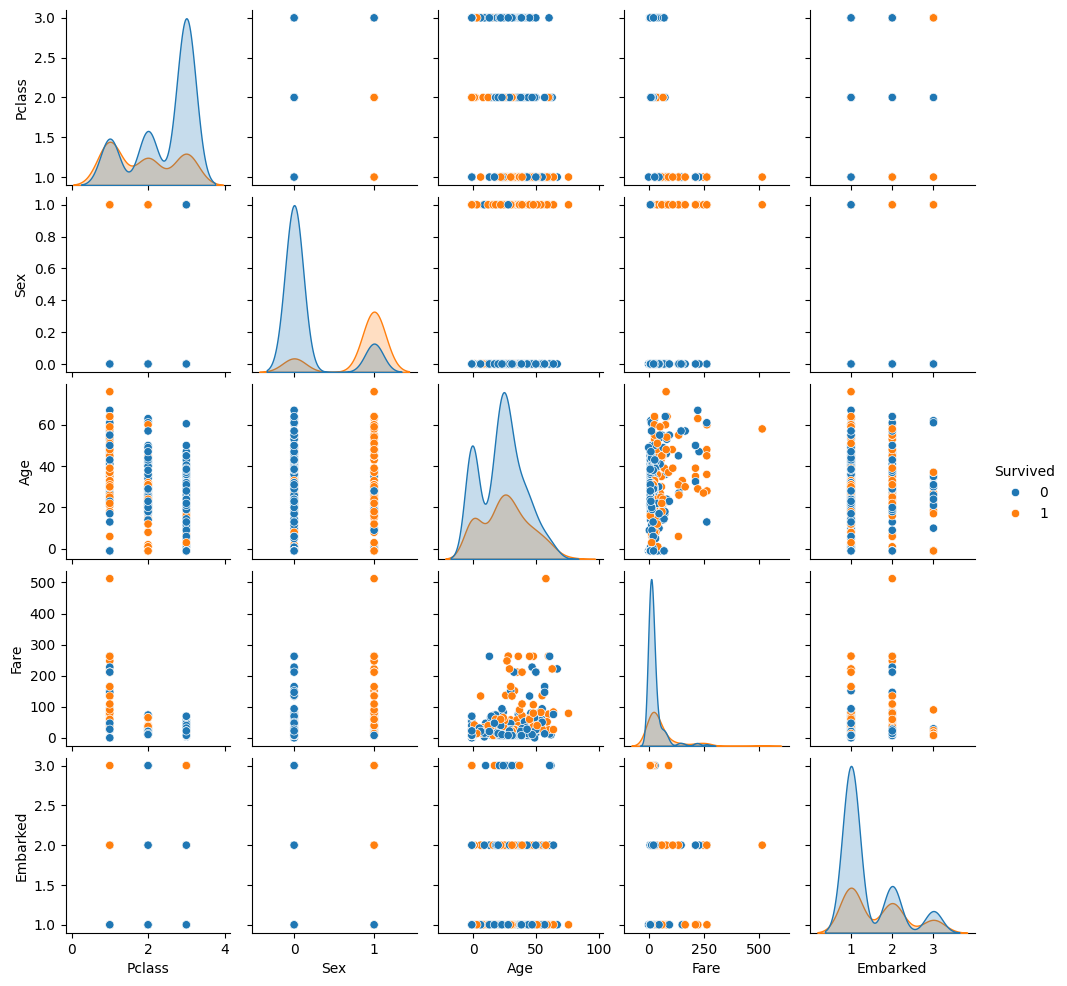

In [18]:
#Visualizar los resultados: gráficos de pares
sns.pairplot(pred_output.drop(['PassengerId'], axis = 1), hue='Survived', height=2)